In [40]:
import re
import pandas as pd
from datetime import datetime

with open('nginx_logs.txt', 'r') as log_file:
    log_lines = log_file.readlines()

In [41]:
def parse_logs(lines):
    log_data = []
    regex = r'(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] "(.*?)" (\d+) (\d+) "(.*?)" "(.*?)"'
    for line in lines:
        match = re.match(regex, line)
        if match:
            groups = match.groups()
            dt = datetime.strptime(groups[1], '%d/%b/%Y:%H:%M:%S %z')
            # request_info = groups[2].split()
            log_data.append({
                'IP': groups[0],
                'Date': dt.date(),
                'Time': dt.time(),
                'Request':  groups[2],
                'Status_Code': int(groups[3]),
                'Size': int(groups[4]),
                'Referer': groups[5],
                'User-Agent': groups[6]})
    return log_data

log_data = parse_logs(log_lines)
df = pd.DataFrame(log_data)

df.head(3)

,IP,Date,Time,Request,Status_Code,Size,Referer,User-Agent
0,93.180.71.3,2015-05-17,08:05:32,GET /downloads/product_1 HTTP/1.1,304,0,-,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.21)
1,93.180.71.3,2015-05-17,08:05:23,GET /downloads/product_1 HTTP/1.1,304,0,-,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.21)
2,80.91.33.133,2015-05-17,08:05:24,GET /downloads/product_1 HTTP/1.1,304,0,-,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.17)


In [42]:
# Визначити кількість користувачів за днями

df.groupby('Date')['IP'].nunique().reset_index(name='Unique_Users')

,Date,Unique_Users
0,2015-05-17,118
1,2015-05-18,248
2,2015-05-19,271
3,2015-05-20,287
4,2015-05-21,279
5,2015-05-22,251
6,2015-05-23,258
7,2015-05-24,260
8,2015-05-25,280
9,2015-05-26,216


In [43]:
# Ранжувати користувачів за User-Agent

df.groupby('User-Agent')['IP'].nunique().sort_values(ascending=False).reset_index(name='Unique_IP').head(10)

,User-Agent,Unique_IP
0,urlgrabber/3.9.1 yum/3.2.29,460
1,urlgrabber/3.9.1 yum/3.4.3,416
2,Debian APT-HTTP/1.3 (0.9.7.9),397
3,Debian APT-HTTP/1.3 (1.0.1ubuntu2),341
4,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.21),183
5,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.22),87
6,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.16),67
7,Chef Client/11.6.2 (ruby-1.9.3-p448; ohai-6.18...,62
8,urlgrabber/3.1.0 yum/3.2.22,55
9,Debian APT-HTTP/1.3 (0.8.10.3),50


In [44]:
# Додавання колонки з ОС

from user_agents import parse

df['OS'] = df['User-Agent'].apply(lambda x: parse(x).os.family)
df['OS'].value_counts().reset_index(name='Count')

,OS,Count
0,Debian,47801
1,Other,1848
2,Linux,1534
3,Windows,142
4,Ubuntu,47
5,Red Hat,31
6,openSUSE,8
7,Mac OS X,1


In [45]:
# Ранжувати користувачів за операційними системами

df.groupby('OS')['IP'].nunique().sort_values(ascending=False).reset_index(name='Unique_IP')

,OS,Unique_IP
0,Debian,1275
1,Other,1029
2,Linux,357
3,Red Hat,15
4,Windows,9
5,Ubuntu,7
6,Mac OS X,1
7,openSUSE,1


In [52]:
# Додавання колонки з країнами

import geoip2.database

def get_country_by_ip(ip_address):
    reader = geoip2.database.Reader('GeoLite2-Country.mmdb')
    
    try:
        response = reader.country(ip_address)
        country_name = response.country.name
        return country_name
    except geoip2.errors.AddressNotFoundError:
        return None
    finally:
        reader.close()

df['Country'] = df['IP'].apply(get_country_by_ip)

df['Country'].value_counts().reset_index(name='Count')

,Country,Count
0,United States,17892
1,Germany,5009
2,Russia,3275
3,The Netherlands,3222
4,United Kingdom,3178
...,...,...
63,Mexico,2
64,Slovenia,1
65,Colombia,1
66,Romania,1


In [53]:
# Ранжувати користувачів за країною запиту

df.groupby('Country')['IP'].nunique().sort_values(ascending=False).reset_index(name='Unique_IP')

,Country,Unique_IP
0,United States,1207
1,Germany,268
2,Ireland,196
3,France,128
4,United Kingdom,126
...,...,...
63,Qatar,1
64,Philippines,1
65,Mexico,1
66,Slovenia,1


In [48]:
# Пошук ботів

def extract_bots(log_lines):
    bot_list = []
    bot_patterns = [
        'Googlebot', 'Bingbot', 'YandexBot', 'DuckDuckBot', 'Baiduspider', 
        'Sogou', 'Exabot', 'facebookexternalhit', 'Facebot', 'archiver', 
        'python', 'fetch', 'facebook', 'monitoring', 'http','scan', 
        'checker', 'analyzer', 'apache', 'java', 'google', 'bing', 
        'yahoo', 'msn', 'bot', 'Twitterbot'
    ]
    
    user_agent_pattern = re.compile(r'".*?"\s+"([^"]+)"')
    
    for line in log_lines:
        match = user_agent_pattern.search(line)
        if match:
            user_agent = match.group(1).lower()
            if any(bot in user_agent for bot in bot_patterns):
                bot_list.append(user_agent)
    
    return list(set(bot_list))

bots = extract_bots(log_lines)
print(bots)

['chef knife/11.8.2 (ruby-1.9.3-p484; ohai-6.14.0; x86_64-linux; +http://opscode.com)', 'chef client/12.0.1 (ruby-2.1.5-p273; ohai-8.0.1; x86_64-linux-gnu; +http://opscode.com)', 'java/1.7.0_65', 'python-requests/2.0.0 cpython/2.6.6 linux/2.6.32-358.18.1.el6.x86_64', 'ubuntu apt-http/1.3 (0.7.25.3ubuntu9.13)', 'debian apt-http/1.3 (0.8.16~exp12ubuntu10.20.1)', 'ubuntu apt-http/1.3 (0.7.25.3ubuntu9.14)', 'chef client/11.6.0 (ruby-1.9.3-p429; ohai-6.18.0; x86_64-linux; +http://opscode.com)', 'debian apt-http/1.3 (0.8.16~exp12ubuntu10.17)', 'debian apt-http/1.3 (0.8.16~exp12ubuntu10.16)', 'chef client/11.14.6 (ruby-1.9.3-p484; ohai-7.2.4; x86_64-linux; +http://opscode.com)', 'chef client/11.8.2 (ruby-1.9.3-p484; ohai-6.22.0; x86_64-linux; +http://opscode.com)', 'ubuntu apt-http/1.3 (0.7.25.3ubuntu9.15)', 'java/1.7.0_51', 'debian apt-http/1.3 (0.9.7.7ubuntu4)', 'debian apt-http/1.3 (0.8.16~exp5ubuntu13.7)', 'debian apt-http/1.3 (0.8.16~exp12ubuntu10.19)', 'chef client/11.10.4 (ruby-1.9.3-p

In [54]:
# Виокремити пошукових ботів

bots = ['mj12bot', 'chlooe', 'googlebot', 'bingbot', 'slurp', 'baidubot', 'yandex', 'duckduckbot', 'curl', 'bot', 'facebookexternalhit', 'twitterbot', 'linkedinbot', 'telegrambot']

df['Bot'] = df['User-Agent'].apply(lambda x: next((bot for bot in bots if bot in x), None))

df['Bot'].value_counts().reset_index(name='Count')


,Bot,Count
0,curl,100
1,bot,1


In [55]:
df.head(5)

,IP,Date,Time,Request,Status_Code,Size,Referer,User-Agent,OS,Country,Bot
0,93.180.71.3,2015-05-17,08:05:32,GET /downloads/product_1 HTTP/1.1,304,0,-,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.21),Debian,The Netherlands,None
1,93.180.71.3,2015-05-17,08:05:23,GET /downloads/product_1 HTTP/1.1,304,0,-,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.21),Debian,The Netherlands,None
2,80.91.33.133,2015-05-17,08:05:24,GET /downloads/product_1 HTTP/1.1,304,0,-,Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.17),Debian,Norway,None
3,217.168.17.5,2015-05-17,08:05:34,GET /downloads/product_1 HTTP/1.1,200,490,-,Debian APT-HTTP/1.3 (0.8.10.3),Debian,United Kingdom,None
4,217.168.17.5,2015-05-17,08:05:09,GET /downloads/product_2 HTTP/1.1,200,490,-,Debian APT-HTTP/1.3 (0.8.10.3),Debian,United Kingdom,None


In [63]:
# Створення DataFrame
df = pd.DataFrame(parse_logs(log_lines))

# 1. Виявлення IP з високою активністю
ip_counts = df['IP'].value_counts()
thresh = ip_counts.mean() + 3 * ip_counts.std()  # Межа аномальної активності
anomalous_ips = ip_counts[ip_counts > thresh]
print("Аномально активні IP:")
print(anomalous_ips)

# 2. Часті 404 помилки
error_404 = df[df['Status_Code'] == 404]['IP'].value_counts()
anomalous_404_ips = error_404[error_404 > error_404.mean() + 2 * error_404.std()]
print("\nIP з великою кількістю 404 помилок:")
print(anomalous_404_ips)

# 3. Аналіз User-Agent
suspicious_agents = df['User-Agent'].value_counts()
anomalous_agents = suspicious_agents[suspicious_agents < suspicious_agents.mean() - 2 * suspicious_agents.std()]
print("\nПідозрілі User-Agent:")
print(anomalous_agents)


Аномально активні IP:
IP
216.46.173.126     2350
180.179.174.219    1720
204.77.168.241     1439
65.39.197.164      1365
80.91.33.133       1202
84.208.15.12       1120
74.125.60.158      1084
119.252.76.162     1064
79.136.114.202      628
54.207.57.55        532
54.183.198.11       495
204.77.169.137      448
54.86.8.9           423
54.77.181.41        401
5.9.28.15           390
74.63.142.188       390
46.29.152.10        380
54.183.135.30       369
209.216.233.52      360
94.75.199.161       359
54.77.28.241        345
54.165.228.106      304
185.40.8.139        295
Name: count, dtype: int64

IP з великою кількістю 404 помилок:
IP
216.46.173.126     1570
180.179.174.219    1285
65.39.197.164       997
74.125.60.158       898
80.91.33.133        870
119.252.76.162      847
204.77.168.241      835
84.208.15.12        672
79.136.114.202      495
54.183.198.11       330
54.207.57.55        315
54.77.181.41        314
94.75.199.161       308
54.86.8.9           282
74.63.142.188       2

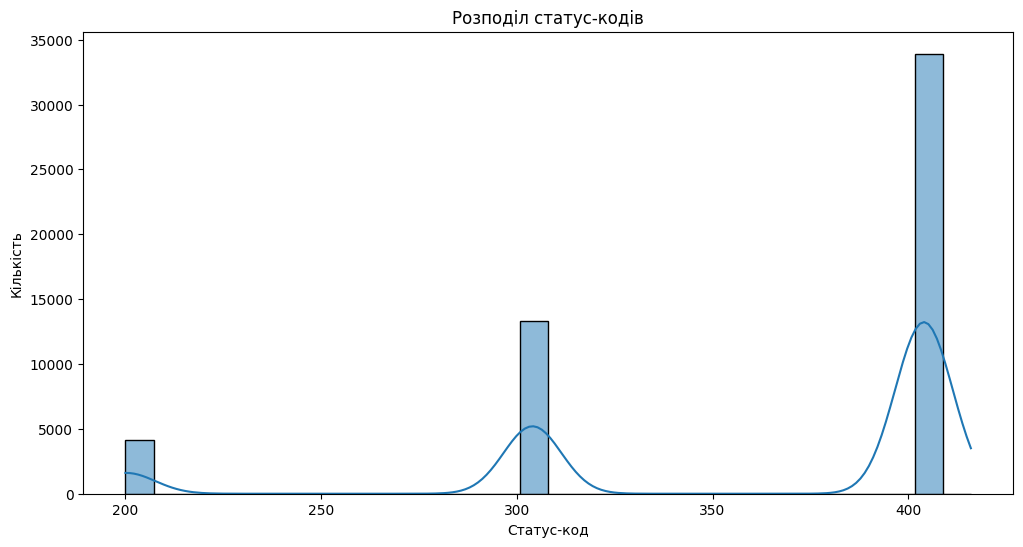

In [64]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Status_Code'], bins=30, kde=True)
plt.title('Розподіл статус-кодів')
plt.xlabel('Статус-код')
plt.ylabel('Кількість')
plt.show()

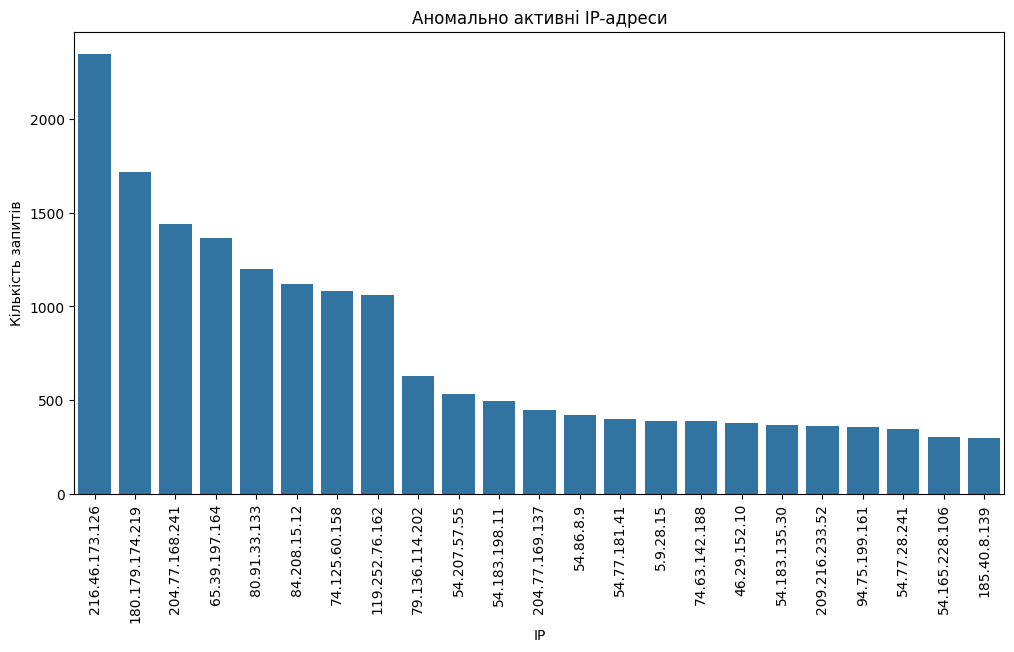

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(x=anomalous_ips.index, y=anomalous_ips.values)
plt.xticks(rotation=90)
plt.title('Аномально активні IP-адреси')
plt.xlabel('IP')
plt.ylabel('Кількість запитів')
plt.show()

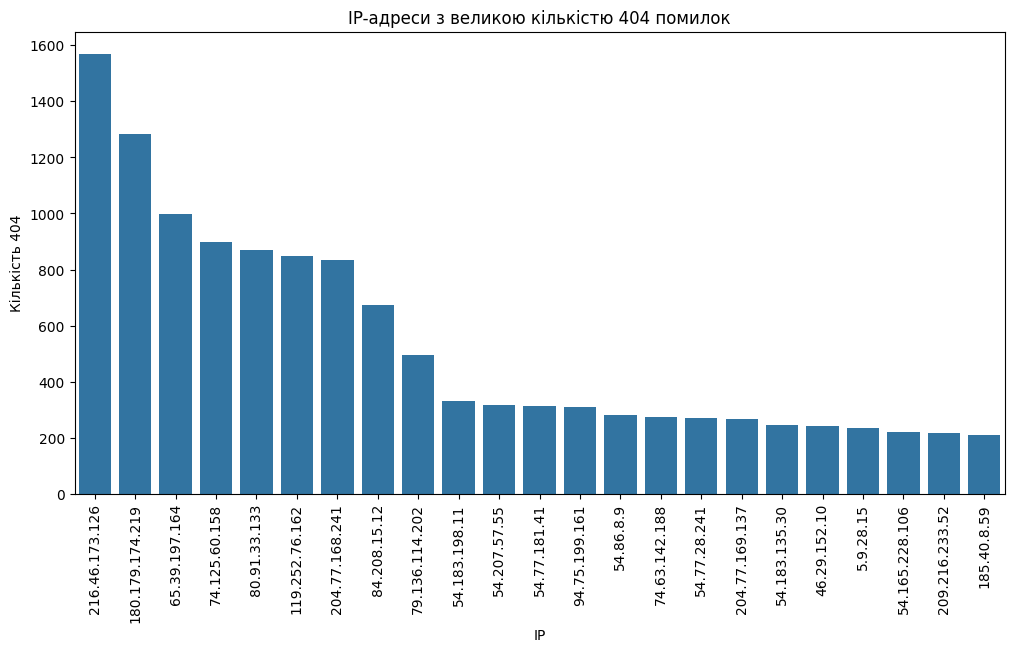

In [66]:
plt.figure(figsize=(12, 6))
sns.barplot(x=anomalous_404_ips.index, y=anomalous_404_ips.values)
plt.xticks(rotation=90)
plt.title('IP-адреси з великою кількістю 404 помилок')
plt.xlabel('IP')
plt.ylabel('Кількість 404')
plt.show()

